## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from variaIa import baserate
from variaIa import stretchevol
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys, $z[:z_{\text{max}}]$, $x_1[:z_{\text{max}}]$, mean, std et données totales

In [2]:
cons = ipw.Checkbox(
    value=False,
    description='Conservative')

In [3]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

surv = {'SNF':  d_snf.loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)],
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

dgmap = plt.cm.get_cmap('viridis')
colors = {'SNF': dgmap(0),
          'SDSS': dgmap(50),
          'PS1': dgmap(125),
          'SNLS': dgmap(200),
          'HST': dgmap(300)}

with open('../Data/zmax_mlim', 'rb') as f:
    z_max = pickle.load(f)
z_max['HST'] = [10, 10]

def set_cons(cons):
    global df
    
    zmax_cuts = dict()
    z_zcuts = dict()
    x1_zcuts = dict()
    x1_err_zcuts = dict()
    
    names = ['SNF' for i in range(len(surv['SNF']['host.zcmb']))]
    stretchs = list(surv['SNF']['salt2.X1'])
    stretchs_err = list(surv['SNF']['salt2.X1.err'])
    redshifts = list(surv['SNF']['host.zcmb'])
    infor = list(surv['SNF']['p(prompt)'])
    py = list(surv['SNF']['p(prompt)'])
    lssfr = list(surv['SNF']['lssfr'])
    lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
    lssfr_err_u = list(surv['SNF']['lssfr.err_up'])
    
    if cons:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][0])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    else:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][-1])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    
    for survey in surveys[1:]:
        names += [survey for i in range(len(z_zcuts[survey]))]
        stretchs += list(x1_zcuts[survey])
        stretchs_err += list(x1_err_zcuts[survey])
        redshifts += list(z_zcuts[survey])
        infor += list(stretchevol.Evol2G2M2S().delta(z_zcuts[survey]))
        py += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr_err_d += list([0 for i in range(len(z_zcuts[survey]))])
        lssfr_err_u += list([0 for i in range(len(z_zcuts[survey]))])
        
    df = pd.DataFrame({'survey': names,
                       'stretchs': stretchs,
                       'stretchs_err': stretchs_err,
                       'redshifts': redshifts,
                       'infor': infor,
                       'py': py,
                       'lssfr': lssfr,
                       'lssfr_err_d': lssfr_err_d,
                       'lssfr_err_u': lssfr_err_u})

    z_mean = np.mean(df.redshifts)
    z_std = np.std(df.redshifts)
    x1_mean = np.mean(df.stretchs)
    x1_std = np.std(df.stretchs)
    
    return(df)
            
int_set_cons = ipw.interactive(set_cons, cons=cons)
display(int_set_cons)

names = ['SNF' for i in range(len(surv['SNF']['host.zcmb'].values))]
stretchs = list(surv['SNF']['salt2.X1'].values)
stretchs_err = list(surv['SNF']['salt2.X1.err'].values)
redshifts = list(surv['SNF']['host.zcmb'].values)
infor = list(surv['SNF']['p(prompt)'])
py = list(surv['SNF']['p(prompt)'])
lssfr = list(surv['SNF']['lssfr'])
lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
lssfr_err_u = list(surv['SNF']['lssfr.err_up'])

for survey in surveys[1:]:
    names += [survey for i in range(len(surv[survey].zCMB.values))]
    stretchs += list(surv[survey].x1.values)
    stretchs_err += list(surv[survey].x1ERR.values)
    redshifts += list(surv[survey].zCMB.values)
    infor += list(stretchevol.Evol2G2M2S().delta(surv[survey].zCMB.values))
    py += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_d += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_u += list([0 for i in range(len(surv[survey].zCMB.values))])

df_full = pd.DataFrame({'survey': names,
                        'stretchs': stretchs,
                        'stretchs_err': stretchs_err,
                        'redshifts': redshifts,
                        'infor': infor,
                        'py': py,
                        'lssfr': lssfr,
                        'lssfr_err_d': lssfr_err_d,
                        'lssfr_err_u': lssfr_err_u})

interactive(children=(Checkbox(value=False, description='Conservative'), Output()), _dom_classes=('widget-inte…

## Minimisation des modèles à mettre dans le _pandas_

In [7]:
########################################### Assym PS1

assymPS1 = stretchevol.Evol1G1M2S()
assymPS1.set_data(df_full[df_full['survey'] == 'PS1'])

print('PS1')

assymPS1.minimize()
# assymPS1.traceur()

########################################### Assym SDSS

assymSDSS = stretchevol.Evol1G1M2S()
assymSDSS.set_data(df_full[df_full['survey'] == 'SDSS'])

print('SDSS')

assymSDSS.minimize()

########################################### Assym SNLS

assymSNLS = stretchevol.Evol1G1M2S()
assymSNLS.set_data(df_full[df_full['survey'] == 'SNLS'])

print('SNLS')

assymSNLS.minimize()

PS1
SDSS
SNLS


## Modèle _base_ pour comparaison

In [5]:
base = stretchevol.Evol3G2M2SSNF()
base.set_data(df[df['survey'] == 'SNF'])

base.minimize()
#base.scatter()

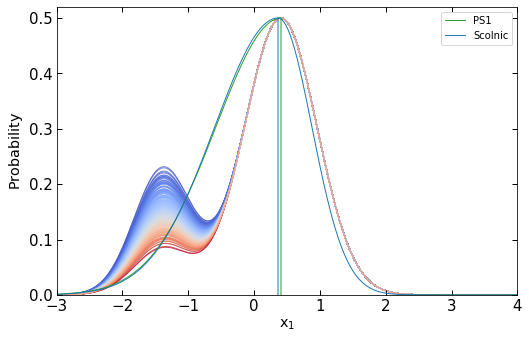

In [8]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

x_linspace = np.linspace(assymPS1.floor, assymPS1.ceil, 3000)
flag_up = x_linspace >= assymPS1.param['mu']

color_p = "C2"

ax.vline(assymPS1.param['mu'], 0, .499,
         color=color_p, alpha=.5, linewidth=2.0)

ax.plot(x_linspace[flag_up],
        (assymPS1.param['sigma_p']) * np.sqrt(np.pi/2) *
        assymPS1.gauss(x_linspace[flag_up],
                       np.zeros(len(x_linspace[flag_up])),
                       assymPS1.param['mu'],
                       assymPS1.param['sigma_p']),
        color=color_p, label='PS1',
        lw=1)
ax.plot(x_linspace[~flag_up],
        (assymPS1.param['sigma_m']) * np.sqrt(np.pi/2) *
        assymPS1.gauss(x_linspace[~flag_up],
                       np.zeros(len(x_linspace[~flag_up])),
                       assymPS1.param['mu'],
                       assymPS1.param['sigma_m']),
        color=color_p,
        lw=1)

mu_s = 0.365
sigma_m_s = 0.963
sigma_p_s = 0.514
flag_up_s = x_linspace >= mu_s

color_s = "C0"

ax.vline(mu_s, 0, .499,
         color=color_s, alpha=.5, linewidth=2.0)

ax.plot(x_linspace[flag_up_s],
        sigma_p_s*np.sqrt(np.pi/2)*
        assymPS1.gauss(x_linspace[flag_up_s],
                       np.zeros(len(x_linspace[flag_up_s])),
                       mu_s,
                       sigma_p_s),
        color=color_s, label='Scolnic',
        lw=1)

ax.plot(x_linspace[~flag_up_s],
        sigma_m_s*np.sqrt(np.pi/2)*
        assymPS1.gauss(x_linspace[~flag_up_s],
                       np.zeros(len(x_linspace[~flag_up_s])),
                       mu_s,
                       sigma_m_s),
        color=color_s,
        lw=1)

dgmap = plt.cm.get_cmap('coolwarm')
nb_base = len(surv['PS1'].zCMB)
i = 0

z_m, z_p = np.percentile(surv['PS1'].zCMB, [0,100])

for z in surv['PS1'].zCMB: #np.linspace(0.05, 1, nb_base)[:-1]:
    pdf = base.likelihood_tot(base.delta(z),
                              x_linspace, np.zeros(len(x_linspace)),
                              base.param['aa'],
                              base.param['mu_1'], base.param['sigma_1'],
                              base.param['mu_2'], base.param['sigma_2'])

    ax.plot(x_linspace,
            0.5/np.max(pdf)*pdf,
            color=dgmap((z-z_m)/(z_p-z_m)), alpha=.7,
            lw=1, zorder=1)
    i += 1

                                                      
ax.tick_params(direction='in',
               length=5, width=1,
               labelsize=15,
               top=True, right=True)
 
ax.set_xlim([assymPS1.floor, assymPS1.ceil])
ax.set_ylim([0, .52])
                                                                      
ax.set_ylabel(r'$\mathrm{Probability}$', fontsize='x-large')
ax.set_xlabel(r'$\mathrm{x}_1$', fontsize='x-large')

ax.legend(ncol=1, loc='upper right')

fig.savefig('../../../Images/bbc_comp.pdf', bbox_inches='tight')

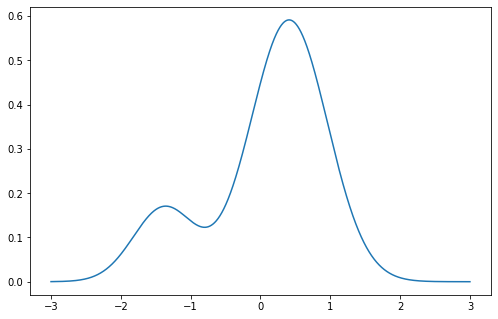

In [17]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

xx = np.linspace(-3, 3, 3000)

snf_a = 0.48
snf_mu_1 = 0.41
snf_sigma_1 = 0.55
snf_mu_2 = -1.38
snf_sigma_2 = 0.44

delta = base.delta(0.3)

pdf_y = scipy.stats.norm.pdf(xx, loc=snf_mu_1, scale=snf_sigma_1)
pdf_o = snf_a*scipy.stats.norm.pdf(xx, loc=snf_mu_1, scale=snf_sigma_1)+\
        (1-snf_a)*scipy.stats.norm.pdf(xx, loc=snf_mu_2, scale=snf_sigma_2)

pdf = delta*pdf_y + (1-delta)*pdf_o
#pdf_tot = base.likelihood_tot(delta, xx, np.zeros(len(xx)),)

ax.plot(xx,
        pdf)

## Get proba

In [6]:
def get_proba(model):
    return np.exp((evol3G2M1S.get_aicc() - model.get_aicc())/2)

In [11]:
modèles = [assymSDSS, assymPS1, assymSNLS]

assym_comp = pd.DataFrame({'Assym': ['SDSS', 'PS1', 'SNLS', 'Total'],
                           'Free param': [len(k.FREEPARAMETERS) for k in modèles] + [np.sum([len(k.FREEPARAMETERS) for k in modèles])],
                           '$\sigma^-$': [round(k.migrad_out[1][1][2],2) for k in modèles] + ['--'],
                           '$\sigma^-_{\mathrm{err}}$': [round(k.migrad_out[1][1][3],2) for k in modèles] + ['--'],
                           '$\sigma^+$': [round(k.migrad_out[1][2][2],2) for k in modèles] + ['--'],
                           '$\sigma^+_{\mathrm{err}}$': [round(k.migrad_out[1][2][3],2) for k in modèles] + ['--'],
                           '$\mu^0$': [round(k.migrad_out[1][0][2],2) for k in modèles] + ['--'],
                           '$\mu^0_{\mathrm{err}}$': [round(k.migrad_out[1][0][3],2) for k in modèles] + ['--'],
                           'ln $\mathcal{L}$': [round(k.get_logl(),1) for k in modèles] + [round(np.sum([k.get_logl() for k in modèles]),1)],
                           'AICc': [round(k.get_aicc(),1) for k in modèles] + [round(np.sum([k.get_aicc() for k in modèles]),1)]})

#path = '../Data/assym_comp'
#if cons.value:
#    path += '_cons'
#path += '.dat'
#assym_comp.to_csv(path)

assym_comp

,Assym,Free param,$\sigma^-$,$\sigma^-_{\mathrm{err}}$,$\sigma^+$,$\sigma^+_{\mathrm{err}}$,$\mu^0$,$\mu^0_{\mathrm{err}}$,ln $\mathcal{L}$,AICc
0,SDSS,3,1.25,0.08,0.39,0.07,0.69,0.1,893.9,900.0
1,PS1,3,1,0.09,-0.49,0.09,0.42,0.12,702.0,708.1
2,SNLS,3,1.18,0.11,0.39,0.11,0.81,0.15,594.8,600.9
3,Total,9,--,--,--,--,--,--,2190.7,2209.0


## Minimisation du modèle SNF et calcul $\mathcal{L}$ pour surveys

In [14]:
########################## Get param for SNF #############################

baseSNF = stretchevol.Evol3G2M2SSNF()
baseSNF.set_data(df[df['survey'] == 'SNF'])

baseSNF.minimize()

##################### Define and compute L for SDSS #####################

baseSDSS = stretchevol.Evol3G2M2S()
baseSDSS.set_data(df[df['survey'] == 'SDSS'])

baseSDSS.minimize()

##################### Define and compute L for PS1 #####################

basePS1 = stretchevol.Evol3G2M2S()
basePS1.set_data(df[df['survey'] == 'PS1'])

basePS1.minimize()

##################### Define and compute L for SNLS #####################

baseSNLS = stretchevol.Evol3G2M2S()
baseSNLS.set_data(df[df['survey'] == 'SNLS'])

baseSNLS.minimize()

In [16]:
models = [basePS1, baseSDSS, baseSNLS]

snf_comp = pd.DataFrame({'Base': ['SDSS', 'PS1', 'SNLS', 'Total'],
                         'Free param': [0 for k in models] + [0],
                         'ln $\mathcal{L}$': [round(k.get_logl(),1) for k in models] + [round(np.sum([k.get_logl() for k in models]),1)],
                         'AICc': [round(k.get_aicc(),1) for k in models] + [round(np.sum([k.get_aicc() for k in models]),1)]})

path = '../Data/snf_comp'
if cons.value:
    path += '_cons'
path += '.dat'
snf_comp.to_csv(path)

snf_comp

,Base,Free param,ln $\mathcal{L}$,AICc
0,SDSS,0,395.2,405.6
1,PS1,0,444.7,455.0
2,SNLS,0,254.1,264.7
3,Total,0,1094.0,1125.4
